<a href="https://colab.research.google.com/github/madrigaljose/madrigaljose/blob/main/20210710_Madrigal_DLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import math
from keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Conv1D, GlobalMaxPooling1D, Flatten, MaxPooling1D
from keras.layers.wrappers import Bidirectional

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

from keras.preprocessing.sequence import TimeseriesGenerator
!pip install pandas-datareader
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 6.3MB 5.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.62-py2.py3-none-any.whl size=23867 sha256=07e4b6bd2ed0a18d7f568cfb19362572a2ae882cd3e4daac229ca4387a472dea
  Stored in directory: /tmp/pip-ephem-wheel-cache-bts0nsef/wheels/38/5c/4a/7266ab5120deea4efa7a6dd8f6f41e913b77500ec3397c9f01
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import pandas_datareader.data as pdr
import yfinance as yf

yf.pdr_override()
df = pdr.get_data_yahoo('DE')#, start, end)
df = df[['Adj Close']]  
df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
1972-06-01,0.691186
1972-06-02,0.704633
1972-06-05,0.701944
1972-06-06,0.695220
1972-06-07,0.687151


In [ ]:
yf.pdr_override()
Corn = pdr.get_data_yahoo('CORN')#, start, end)
Corn[['Corn_Open']] = Corn[['Open']]  
Corn=Corn[['Corn_Open']]
Corn.head()

[*********************100%***********************]  1 of 1 completed


,Corn_Open
Date,
2010-06-09,25.120001
2010-06-10,25.459999
2010-06-11,25.879999
2010-06-14,25.990000
2010-06-15,26.240000


In [ ]:
yf.pdr_override()
Wheat = pdr.get_data_yahoo('WEAT')#, start, end)
Wheat['Wheat_Open']=Wheat[['Open']]
Wheat = Wheat[['Wheat_Open']]  

yf.pdr_override()
Soy = pdr.get_data_yahoo('SOYB')#, start, end)
Soy['Soy_Open'] = Soy[['Open']]  
Soy=Soy[['Soy_Open']]

yf.pdr_override()
Sugar = pdr.get_data_yahoo('CANE')#, start, end)
Sugar['Sugar_Open'] = Sugar[['Open']]  
Sugar=Sugar[['Sugar_Open']]

yf.pdr_override()
Deere = pdr.get_data_yahoo('DE')#, start, end)
Deere['Deere_Close'] = Deere[['Adj Close']]  
Deere=Deere[['Deere_Close']]



#CORN.head()
#Wheat.head()
#Soy.head()
#Sugar.head()
Deere.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Deere_Close
Date,
1972-06-01,0.691186
1972-06-02,0.704633
1972-06-05,0.701944
1972-06-06,0.695220
1972-06-07,0.687151


In [ ]:
Combined_df=Corn.join(Wheat, how='inner').join(Soy, how='inner').join(Sugar, how='inner').join(Deere, how='inner')


In [ ]:
Combined_df

,Corn_Open,Wheat_Open,Soy_Open,Sugar_Open,Deere_Close
Date,,,,,
2011-09-19,45.459999,24.570000,24.549999,25.110001,62.006783
2011-09-20,46.110001,24.680000,24.990000,25.270000,61.034782
2011-09-21,45.900002,24.410000,24.959999,24.580000,58.496346
2011-09-22,43.959999,23.709999,24.000000,23.980000,55.098400
2011-09-23,42.990002,23.320000,24.430000,23.330000,54.198704
...,...,...,...,...,...
2021-07-02,21.340000,6.650000,23.879999,8.560000,352.500000
2021-07-06,20.980000,6.550000,23.650000,8.650000,349.450012
2021-07-07,19.719999,6.290000,22.600000,8.450000,351.880005


NameError: ignored

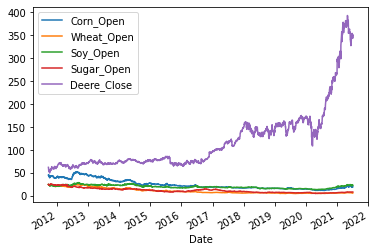

In [ ]:
Combined_df.plot()
plt.show()

In [ ]:
dataset = df.values.astype('float32')
dataset

array([[  0.6911858],
       [  0.704633 ],
       [  0.7019436],
       ...,
       [351.88     ],
       [343.58     ],
       [349.48     ]], dtype=float32)

In [ ]:
dataset.shape

(12384, 1)

In [ ]:
split_pct = 0.8

split = int(split_pct*len(dataset))

train = dataset[:split]
valid = dataset[split:]

print(len(train))
print(len(valid))

train.shape, valid.shape

9907
2477


((9907, 1), (2477, 1))

In [ ]:
lags = 30

train_generator = TimeseriesGenerator(train, train, length=lags, batch_size=5)
valid_generator = TimeseriesGenerator(valid, valid, length=lags, batch_size=1)

In [ ]:
train_generator[0][1]

array([[0.6656362 ],
       [0.66698056],
       [0.6683252 ],
       [0.67235947],
       [0.6683252 ]], dtype=float32)

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(lags, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_generator, epochs=10, verbose=2, validation_data=valid_generator)

Epoch 1/10
1976/1976 - 41s - loss: 48.0008 - val_loss: 11302.2812
Epoch 2/10
1976/1976 - 38s - loss: 5.0918 - val_loss: 9331.1641
Epoch 3/10
1976/1976 - 38s - loss: 2.0231 - val_loss: 9318.4287
Epoch 4/10
1976/1976 - 38s - loss: 1.9319 - val_loss: 8749.5566
Epoch 5/10
1976/1976 - 38s - loss: 0.9974 - val_loss: 8110.0132
Epoch 6/10
1976/1976 - 38s - loss: 0.7872 - val_loss: 8370.8652
Epoch 7/10
1976/1976 - 39s - loss: 0.6053 - val_loss: 8372.2227
Epoch 8/10
1976/1976 - 38s - loss: 0.6613 - val_loss: 7897.3828
Epoch 9/10
1976/1976 - 38s - loss: 0.4904 - val_loss: 8137.6460
Epoch 10/10
1976/1976 - 38s - loss: 0.5205 - val_loss: 8411.2510


In [ ]:
# skip this cell if you used scaling
y_valid = np.array([t[1][0] for t in valid_generator])
y_preds=model.predict(valid_generator)

y_valid.shape

(2447, 1)

In [ ]:
math.sqrt(mean_squared_error(y_valid.reshape(-1), y_preds.reshape(-1)))

88.50654879548462

In [ ]:
y_preds.reshape(-1)[0:3]

array([57.542248, 57.6139  , 56.94195 ], dtype=float32)

In [ ]:
y_valid.reshape(-1)[0:3]

array([56.669888, 55.84565 , 55.9588  ], dtype=float32)

In [ ]:
def ts_predict(data, lags, num_periods, model, scaler=None):
    if scaler is not None:
      preds = scaler.transform(data[-lags:])
    
      for _ in range(num_periods):
          preds = np.append(preds, model.predict(preds[-lags:].reshape((1, lags, 1)))[0][0])
          
      return scaler.inverse_transform(preds[lags:])
    else:
      preds = data[-lags:]
    
      for _ in range(num_periods):
          preds = np.append(preds, model.predict(preds[-lags:].reshape((1, lags, 1)))[0][0])
          
      return preds[lags:]

In [ ]:
dataset[-lags:]

array([[361.2783 ],
       [360.17117],
       [363.67212],
       [355.79245],
       [357.98682],
       [355.72266],
       [354.51575],
       [355.66278],
       [348.63092],
       [340.56174],
       [340.6914 ],
       [334.6769 ],
       [337.23035],
       [335.69427],
       [327.53534],
       [328.1238 ],
       [337.0109 ],
       [341.22003],
       [346.8555 ],
       [349.7181 ],
       [349.08972],
       [348.99002],
       [348.93   ],
       [352.71   ],
       [354.29   ],
       [352.5    ],
       [349.45   ],
       [351.88   ],
       [343.58   ],
       [349.48   ]], dtype=float32)

In [ ]:
ts_predict(dataset, lags=lags, num_periods=5, model=model)

array([45.476215, 64.89153 , 71.90612 , 73.183754, 72.94365 ],
      dtype=float32)